## HW5:

В домашньому завданні до даного модулю ви потренуєтесь робити тестове завдання для влаштування на роботу. 
За даними акселерометра з мобільного телефону потрібно класифікувати, якою діяльністю займається людина: йде, стоїть, біжить чи йде по сходах. 
Знайти датасет ви можете за посиланням....

Використайте алгоритми SVM та випадковий ліс з бібліотеки scikit-learn. Як характеристики можете брати показники з акселерометра, проте щоб покращити результати роботи алгоритмів, спочатку можна підготувати наш датасет і розрахувати часові ознаки (time domain features). Більше ці характеристики описані в даній статті.

Порівняйте результати роботи обох алгоритмів на різних фічах та різні моделі між собою.

In [42]:
import math as m
from pathlib import Path
import pickle
from typing import Union

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.svm import SVC
%matplotlib inline

## Data preparation:

In [43]:
def read_from_csvfile(file: Path) -> pd.DataFrame:
    """Read content from csv-file and return dataframe from content."""
    df = pd.read_csv(file)
    
    return df

In [44]:
df = pd.DataFrame()
classification_human_activity = {}

- https://www.geeksforgeeks.org/different-ways-to-create-pandas-dataframe/
- https://pandas.pydata.org/docs/reference/api/pandas.concat.html
- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.std.html
- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.skew.html
- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.kurt.html
- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.var.html
- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.idxmax.html
- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.idxmin.html
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.entropy.html
- https://stackoverflow.com/questions/53177327/how-to-compute-shannon-entropy-of-information-from-a-pandas-dataframe
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html

In [45]:
def get_statistical_features(y: str, df: pd.DataFrame) -> pd.DataFrame:
    # y - type real data; df - sample data. 
    if y not in classification_human_activity:
        classification_human_activity[y] = len(classification_human_activity)

    data = {'activity': [classification_human_activity[y]]}

    [data.update({
                  f'max_{col[-1]}':[max(df[col])],
                  f'min_{col[-1]}':[min(df[col])],
                  f'mean_{col[-1]}':[df[col].mean(axis=0)],
                  f'med_{col[-1]}':[df[col].median(axis=0)],  # median
                  f'std_{col[-1]}':[df[col].std(axis=0)],  # Standard deviation
                  f'skew_{col[-1]}':[df[col].skew(axis=0)],  # skewness
                  f'kurt_{col[-1]}':[df[col].kurt(axis=0)],  # kurtosis
                  f'var_{col[-1]}':[df[col].var(axis=0)],  # variance
                  f'idxmax_{col[-1]}':[df[col].idxmax(axis=0)],  # index of first occurrence of maximum over requested axis
                  f'idxmin_{col[-1]}':[df[col].idxmin(axis=0)],  # index of first occurrence of minimum over requested axis
                  }) 
        for col in df.columns]

    [data.update({
                  f'rmse_{col[-1]}':[mean_squared_error(df[col], [data[f'mean_{col[-1]}'] for __ in range(df.shape[0])], squared=False)],  # variance# Root Mean Square Error
                  f'mae_{col[-1]}':[mean_absolute_error(df[col], [data[f'mean_{col[-1]}'] for __ in range(df.shape[0])])],  # mean absolute error
                  }) 
        for col in df.columns]
    
    df_f = pd.DataFrame(data)
    
    return df_f

In [46]:
def get_data_to_dafaframe(path: Union[str, Path], df: pd.DataFrame) -> pd.DataFrame:
    path = Path(path)
    if not path.is_dir() or not path.exists():
        return None
    
    for file_system_object in path.iterdir():
        if file_system_object.is_dir():
            df = get_data_to_dafaframe(file_system_object, df)
            
        elif file_system_object.suffix.lower() in ('.csv',):
            df_add = read_from_csvfile(file_system_object)
            df = pd.concat([df, get_statistical_features(file_system_object.stem.split('-')[0], df_add)], ignore_index=True)

    return df

In [47]:
def save_prepared_data(df: pd.DataFrame, file_name: str='data1.bin') -> None:
    with open(file_name, 'wb') as fh:
        pickle.dump(df, fh)


In [48]:
def load_prepared_data(file_name: str='data1.bin') -> pd.DataFrame:
    with open(file_name, 'rb') as fh:
        df = pickle.load(fh)

    return df

Якщо немає підготовлених даних (data0.bin & data1.bin) - обробляємо знову з сирих

In [49]:
if Path('data0.bin').is_file() and Path('data1.bin').is_file():
    df = load_prepared_data()
    classification_human_activity = load_prepared_data('data0.bin')

else:
    df = get_data_to_dafaframe('data', df)
    save_prepared_data(df)
    save_prepared_data(classification_human_activity, 'data0.bin')

In [50]:
df.tail(6)

,activity,max_X,min_X,mean_X,med_X,std_X,skew_X,kurt_X,var_X,idxmax_X,...,kurt_Z,var_Z,idxmax_Z,idxmin_Z,rmse_X,mae_X,rmse_Y,mae_Y,rmse_Z,mae_Z
6456,3,1.024718,-10.036493,-3.997519,-3.380613,3.011451,-0.338673,-0.557672,9.068838,5,...,0.374707,6.062126,26,21,2.960835,2.408620,4.719099,3.860922,2.420755,1.881598
6457,3,8.398860,-6.224924,0.826638,1.244985,2.653484,-0.012359,2.275576,7.040978,8,...,9.031841,30.027026,7,11,2.608884,1.942251,3.153400,2.494843,5.387590,3.226745
6458,3,12.196063,-6.354211,2.587334,2.506730,3.311198,-0.104480,3.238238,10.964034,16,...,4.507524,10.078007,28,16,3.255544,2.209689,5.150007,4.039338,3.121230,1.975557
6459,3,8.073248,-4.582502,2.830745,3.447650,3.302172,-0.492919,-0.453013,10.904337,11,...,3.758635,20.366468,27,29,3.246669,2.650009,4.630977,3.314692,4.437069,2.838800
6460,3,9.035717,-6.904877,-0.025219,-0.399831,3.414785,0.284005,0.775833,11.660759,1,...,2.128289,19.916885,1,29,3.357390,2.592356,5.177956,3.986420,4.387823,2.956030
6461,3,8.398860,-6.224924,0.964544,1.376666,2.958615,-0.059084,0.721621,8.753403,20,...,4.863290,39.297190,19,23,2.908887,2.250614,4.252132,3.073357,6.163382,4.058800


Розшифровка позначень типів діяльності

In [51]:
classification_human_activity

{'walking': 0, 'running': 1, 'idle': 2, 'stairs': 3}

In [52]:
if not classification_human_activity.get(0):
    classification_human_activity = {val:key for key, val in classification_human_activity.items()}

classification_human_activity

{0: 'walking', 1: 'running', 2: 'idle', 3: 'stairs'}

In [53]:
X = df.iloc[:, 1:]
y = df.iloc[:, 0]

- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

(рандомне перемішування даних shuffle=True може суттєво впливати на результати співставлення різних алгоритмів, усереднено - орієнтовно достатня точність)

In [54]:
y = y.values

In [55]:
# Робимо вибірки - розділяємо всі дані на групи для тренування, валідаційну та тестову (stratify для рівномірного розподілу за значенням y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, stratify=y)  # random_state=42
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=True, stratify=y_test)
X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape

((4329, 36), (1066, 36), (1067, 36), (4329,), (1066,), (1067,))

## SVC Model training

Натренуємо модельки (ймовірність - probability)

In [57]:
C = [10**q for q in range(-3, 4)]  # 7
gamma = [10**g for g in range(-2, 1)]  # 3+
gamma.append('auto')
degree = [d for d in range(2,7)]  # 6
models_svc_linear = {f'linear>C={coef_C}':SVC(kernel='linear', C=coef_C, probability=True).fit(X_train, y_train) for coef_C in C}
models_svc_rbf = {f'rbf>C={coef_C};g={coef_g}': SVC(kernel='rbf', C=coef_C, gamma=coef_g, probability=True).fit(X_train, y_train) for coef_C in C for coef_g in gamma}
models_svc_poly = {f'poly>C={coef_C};d={deg}': SVC(kernel='poly', degree=deg, C=coef_C, probability=True).fit(X_train, y_train) for coef_C in C for deg in degree}

- https://towardsdatascience.com/predict-vs-predict-proba-scikit-learn-bdc45daa5972

In [58]:
# отримаємо значення моделей за валідаційними/тестовими вибірками і перевіримо узагальнену точність [accuracy_score, f1_score, ]
def run_model(model: SVC, new_data: pd.DataFrame, real_result: pd.Series) -> list:
    y_valid_pred = model.predict_proba(new_data)  # [:, 2]  # probability for classification_human_activity[2]
    from_model_by_max = pd.DataFrame(y_valid_pred).idxmax(1).values
    m1 = accuracy_score(real_result, from_model_by_max)
    m2 = f1_score(real_result, from_model_by_max, average='weighted')  # None = for each class
    
    return [m1, m2]

In [59]:
# обрахуємо результати перевірки за моделями (валідації/тесту)
def get_model_results(
                      X_valid: pd.DataFrame, 
                      y_valid: pd.Series, 
                      models_svc_linear: dict=None, 
                      models_svc_rbf: dict=None, 
                      models_svc_poly: dict=None
                      ) -> pd.DataFrame:
    valid_linear = {mark:run_model(model, X_valid, y_valid) for mark, model in models_svc_linear.items()} if models_svc_linear else {}
    valid_rbf = {mark:run_model(model, X_valid, y_valid) for mark, model in models_svc_rbf.items()} if models_svc_rbf else {}
    valid_poly = {mark:run_model(model, X_valid, y_valid) for mark, model in models_svc_poly.items()} if models_svc_poly else {}

    valid_results = {}
    valid_results.update(valid_linear)
    valid_results.update(valid_rbf)
    valid_results.update(valid_poly)
    valid_results = pd.DataFrame(valid_results).T

    valid_results.columns = ['accuracy_score', 'f1_score', ]

    return valid_results


In [60]:
# Порахуємо результати узагальнених точностей за моделями для різних вибірок
train_results = get_model_results(X_train, y_train, models_svc_linear, models_svc_rbf, models_svc_poly)
valid_results = get_model_results(X_valid, y_valid, models_svc_linear, models_svc_rbf, models_svc_poly)
test_results = get_model_results(X_test, y_test, models_svc_linear, models_svc_rbf, models_svc_poly)

In [61]:
# Порівняємо результати візуально
def show_compare_accuracy_scatter(x: pd.Series, data: pd.DataFrame) -> None:
    plt.figure(figsize=(16,7))
    [ax := sns.scatterplot(x=x, y=ac, data=data, label=ac) for ac in valid_results.columns]

    plt.xticks(rotation=85)
    plt.ylabel('accuracy value', fontsize='small', color='midnightblue')
    plt.grid()
    ax.legend()
    plt.show()

- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sort_values.html
- https://www.geeksforgeeks.org/how-to-sort-pandas-dataframe/

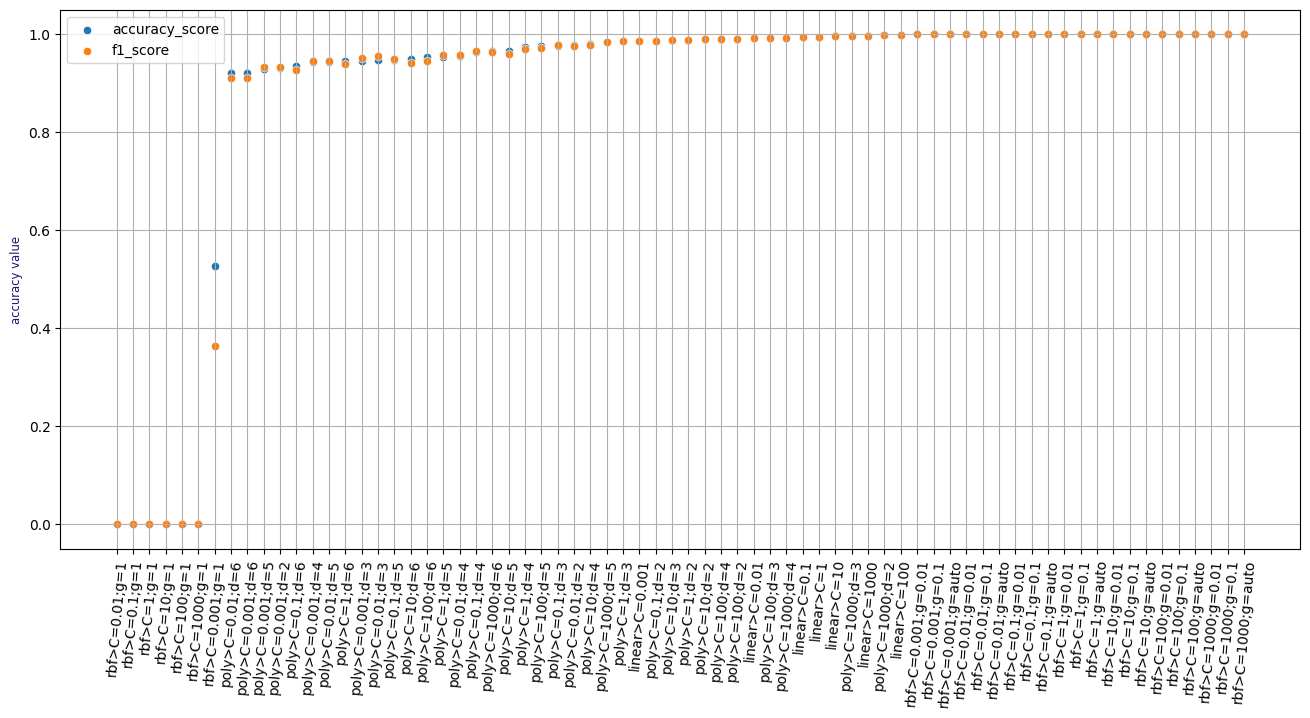

In [62]:
# Порівняння точності за тренувальними вибірками для різних моделей
train_results = train_results.sort_values(by=['accuracy_score', 'f1_score'])
show_compare_accuracy_scatter(x=train_results.index, data=train_results)

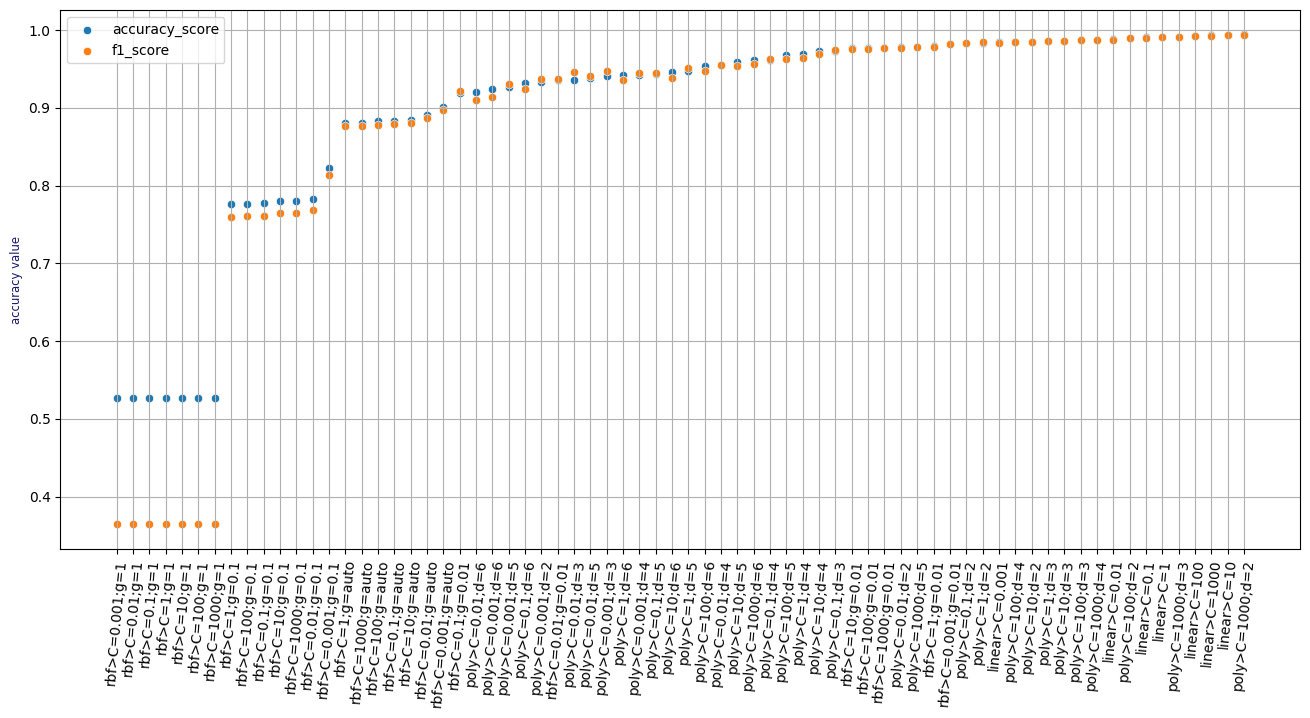

In [63]:
# Порівняння точності за валідаційними вибірками для різних моделей
valid_results = valid_results.sort_values(by=['accuracy_score', 'f1_score'])
show_compare_accuracy_scatter(x=valid_results.index, data=valid_results)

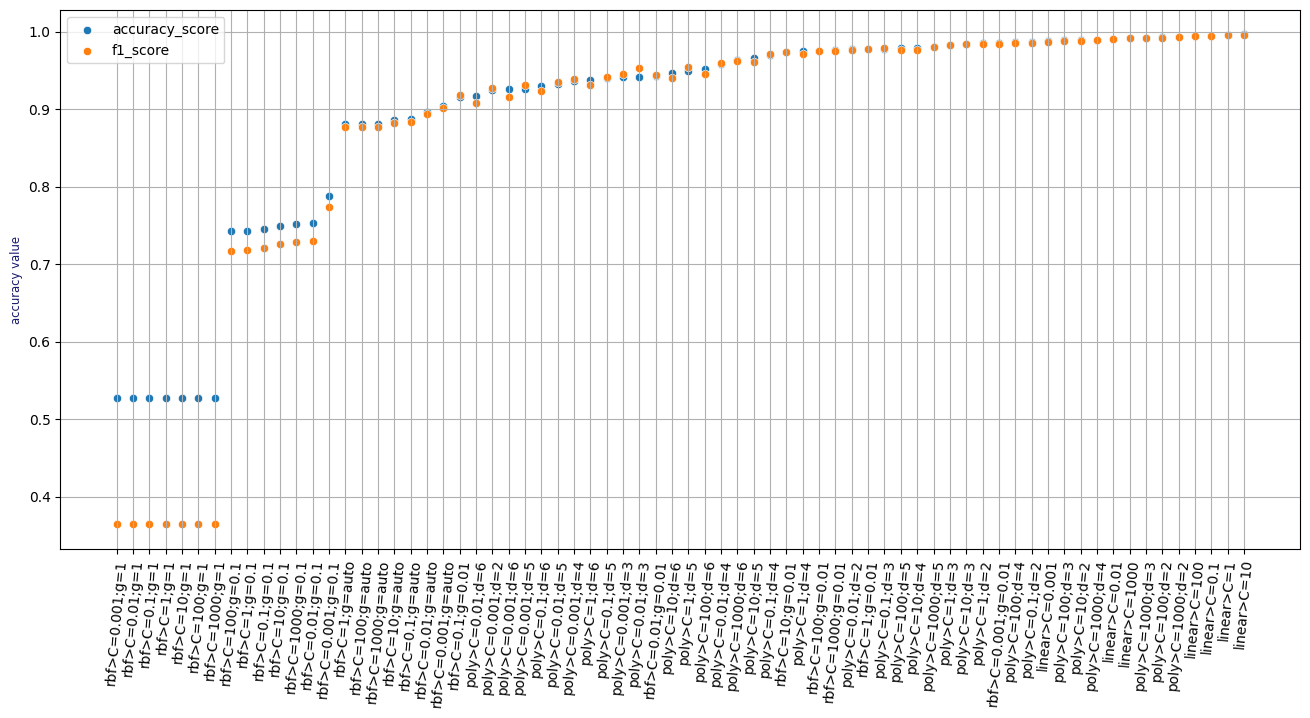

In [64]:
# Порівняння точності за тестовими вибірками для різних моделей
test_results = test_results.sort_values(by=['accuracy_score', 'f1_score'])
show_compare_accuracy_scatter(x=test_results.index, data=test_results)

In [65]:
train_results[train_results['accuracy_score'] >= 0.995]

,accuracy_score,f1_score
linear>C=1,0.995611,0.995546
linear>C=10,0.996997,0.996965
poly>C=1000;d=3,0.997228,0.997228
linear>C=1000,0.997921,0.997881
poly>C=1000;d=2,0.998152,0.998144
linear>C=100,0.998845,0.998843
rbf>C=0.001;g=0.01,1.000000,1.000000
rbf>C=0.001;g=0.1,1.000000,1.000000
rbf>C=0.001;g=auto,1.000000,1.000000
rbf>C=0.01;g=0.01,1.000000,1.000000


In [66]:
# Подивимося на 'найкращі' моделі за результатом роботи моделей для різних вибірок
valid_results.iloc[-4:], test_results.iloc[-4:]

(                 accuracy_score  f1_score
 linear>C=100           0.992495  0.992063
 linear>C=1000          0.993433  0.992982
 linear>C=10            0.993433  0.993125
 poly>C=1000;d=2        0.994371  0.994165,
               accuracy_score  f1_score
 linear>C=100        0.994377  0.994053
 linear>C=0.1        0.994377  0.994278
 linear>C=1          0.995314  0.995188
 linear>C=10         0.996251  0.996113)

In [67]:
"""
Варіант з перемішуванням 1:
(                 accuracy_score  f1_score
 linear>C=0.1           0.993433  0.993181
 linear>C=1             0.993433  0.993181
 poly>C=1000;d=2        0.995310  0.995124
 poly>C=1000;d=3        0.997186  0.997121,
                  accuracy_score  f1_score
 linear>C=1             0.996251  0.996113
 poly>C=1000;d=2        0.996251  0.996185
 poly>C=1000;d=3        0.996251  0.996185
 linear>C=100           0.997188  0.997164)

 Варіант з перемішуванням 2:
 (                 accuracy_score  f1_score
 linear>C=1000           0.99531  0.995094
 linear>C=1              0.99531  0.995242
 linear>C=0.1            0.99531  0.995373
 poly>C=1000;d=2         0.99531  0.995373,
                  accuracy_score  f1_score
 linear>C=100           0.993440  0.993282
 linear>C=10            0.994377  0.994377
 poly>C=1000;d=3        0.997188  0.997167
 poly>C=1000;d=2        1.000000  1.000000)

Варіант з перемішуванням 3:
(               accuracy_score  f1_score
 linear>C=100         0.993433  0.993381
 linear>C=1000        0.993433  0.993484
 linear>C=1           0.994371  0.994371
 linear>C=10          0.995310  0.995272,
                  accuracy_score  f1_score
 linear>C=1000          0.990628  0.990262
 linear>C=1             0.990628  0.990628
 poly>C=1000;d=3        0.992502  0.992194
 poly>C=1000;d=2        0.996251  0.996203)

 Варіант з перемішуванням 5:
 (                 accuracy_score  f1_score
 linear>C=0.1           0.993433  0.993037
 linear>C=0.01          0.993433  0.993162
 poly>C=1000;d=2        0.994371  0.994086
 linear>C=1             0.995310  0.995198,
                  accuracy_score  f1_score
 poly>C=100;d=3         0.992502  0.992507
 poly>C=100;d=2         0.994377  0.994285
 poly>C=1000;d=3        0.995314  0.995197
 poly>C=1000;d=2        0.997188  0.997118)

Варіант з перемішуванням 6:

"""


'\nВаріант з перемішуванням 1:\n(                 accuracy_score  f1_score\n linear>C=0.1           0.993433  0.993181\n linear>C=1             0.993433  0.993181\n poly>C=1000;d=2        0.995310  0.995124\n poly>C=1000;d=3        0.997186  0.997121,\n                  accuracy_score  f1_score\n linear>C=1             0.996251  0.996113\n poly>C=1000;d=2        0.996251  0.996185\n poly>C=1000;d=3        0.996251  0.996185\n linear>C=100           0.997188  0.997164)\n\n Варіант з перемішуванням 2:\n (                 accuracy_score  f1_score\n linear>C=1000           0.99531  0.995094\n linear>C=1              0.99531  0.995242\n linear>C=0.1            0.99531  0.995373\n poly>C=1000;d=2         0.99531  0.995373,\n                  accuracy_score  f1_score\n linear>C=100           0.993440  0.993282\n linear>C=10            0.994377  0.994377\n poly>C=1000;d=3        0.997188  0.997167\n poly>C=1000;d=2        1.000000  1.000000)\n\nВаріант з перемішуванням 3:\n(               accu

In [68]:
# орієнтовно зважено можна сказати, що poly>C=1000;d=2, poly>C=1000;d=3, та linear> одні з найкащих
# Розглянемо linear>C=1
first_result = (train_results.loc['linear>C=1'], valid_results.loc['linear>C=1'], test_results.loc['linear>C=1'])
first_result

(accuracy_score    0.995611
 f1_score          0.995546
 Name: linear>C=1, dtype: float64,
 accuracy_score    0.991557
 f1_score          0.991161
 Name: linear>C=1, dtype: float64,
 accuracy_score    0.995314
 f1_score          0.995188
 Name: linear>C=1, dtype: float64)

In [69]:
best_model = models_svc_linear.get('linear>C=1')

In [70]:
X.columns

Index(['max_X', 'min_X', 'mean_X', 'med_X', 'std_X', 'skew_X', 'kurt_X',
       'var_X', 'idxmax_X', 'idxmin_X', 'max_Y', 'min_Y', 'mean_Y', 'med_Y',
       'std_Y', 'skew_Y', 'kurt_Y', 'var_Y', 'idxmax_Y', 'idxmin_Y', 'max_Z',
       'min_Z', 'mean_Z', 'med_Z', 'std_Z', 'skew_Z', 'kurt_Z', 'var_Z',
       'idxmax_Z', 'idxmin_Z', 'rmse_X', 'mae_X', 'rmse_Y', 'mae_Y', 'rmse_Z',
       'mae_Z'],
      dtype='object')

In [71]:
best_model.coef_


array([[-1.25302105e-02, -1.02517229e-02, -1.08780426e-02,
        -1.10215153e-02, -1.03423074e-03, -3.04623240e-04,
         1.97134093e-03, -1.00808259e-02,  5.21346616e-03,
         2.97711470e-03, -2.10241046e-02, -3.75492421e-02,
        -4.30601696e-02, -4.55752369e-02,  1.77744990e-04,
         2.96939613e-03,  6.70265391e-03, -2.97617688e-03,
        -1.64433753e-03, -2.63859104e-03,  5.85684500e-03,
        -5.97974118e-03, -1.04488917e-02, -8.70685015e-03,
        -4.75190336e-04,  1.82644136e-03,  9.87320109e-03,
        -2.19855375e-03, -1.64377170e-03, -3.53027533e-04,
        -1.01684747e-03, -9.43199842e-04,  1.74757466e-04,
        -1.07263847e-03, -4.67203375e-04, -2.65592642e-03],
       [-3.52931777e-03, -1.17928632e-02, -5.15487200e-03,
        -4.75125863e-03,  3.15149299e-03, -1.88279835e-03,
        -1.00493752e-02,  1.19321415e-02, -7.80878701e-04,
        -2.40443257e-04, -1.35243650e-02, -2.40210776e-02,
        -2.05155843e-02, -1.73625109e-02,  1.42430487e-

In [72]:
data = pd.DataFrame(best_model.coef_)
data.columns = X.columns
data = data.abs()
data = data.iloc[-1].sort_values()
biggest = data[data.values >= 0.5*data.max()].index
biggest

Index(['max_Y', 'med_Y', 'mean_Z', 'mean_Y', 'med_Z', 'min_Z', 'min_Y'], dtype='object')

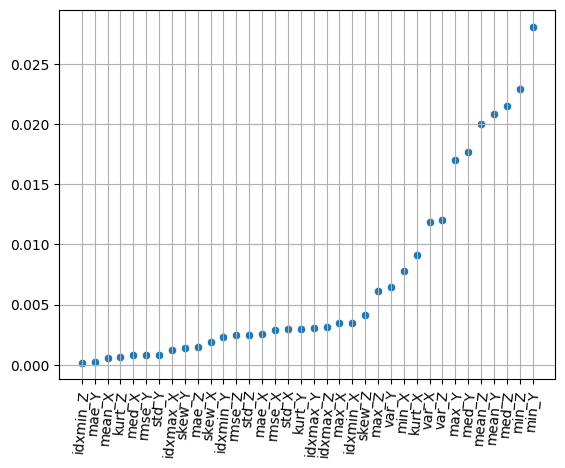

In [73]:
plt.figure()
sns.scatterplot(x=data.index, y=data.values, data=data)
plt.xticks(rotation=85)
plt.grid()
plt.show()

In [74]:
X = X.filter(items=[col for col in biggest])
X

,max_Y,med_Y,mean_Z,mean_Y,med_Z,min_Z,min_Y
0,-1.470040,-10.249578,-0.793758,-9.659965,-0.938527,-14.695610,-17.980455
1,-0.311246,-9.866505,0.218830,-10.444944,-1.781286,-16.223110,-22.443247
2,0.311246,-12.035652,-2.173296,-11.915463,-1.072602,-25.182213,-27.140670
3,8.834604,-11.935095,-2.455174,-10.401370,-0.926556,-33.949780,-28.773516
4,3.586514,-8.980650,-1.350170,-8.448340,-0.723048,-20.216639,-16.314090
...,...,...,...,...,...,...,...
6457,-2.715025,-9.035717,-4.078762,-8.694463,-3.584120,-26.230873,-17.501614
6458,3.016694,-8.477868,-1.258233,-9.039388,-1.067814,-11.789049,-21.049822
6459,2.973599,-7.153874,-0.104068,-7.161376,0.019154,-14.422671,-17.300500
6460,-1.489193,-9.631874,-0.760239,-9.817344,-0.955286,-10.491392,-22.720974


In [75]:
# Робимо вибірки - розділяємо лише важливіші дані на групи для тренування, валідаційну та тестову
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, stratify=y)  # random_state=42
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=True, stratify=y_test)
X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape

((4329, 7), (1066, 7), (1067, 7), (4329,), (1066,), (1067,))

# повторимо створення та оцінку моделей для лише за 'найвагомішими' параметрами

In [76]:
# C = [10**q for q in range(-3, 4)]  # 7
# gamma = [10**g for g in range(-2, 1)]  # 3+
# gamma.append('auto')
# degree = [d for d in range(2,7)]  # 6
models_svc_linear = {f'linear>C={coef_C}':SVC(kernel='linear', C=coef_C, probability=True).fit(X_train, y_train) for coef_C in C}
models_svc_rbf = {f'rbf>C={coef_C};g={coef_g}': SVC(kernel='rbf', C=coef_C, gamma=coef_g, probability=True).fit(X_train, y_train) for coef_C in C for coef_g in gamma}
models_svc_poly = {f'poly>C={coef_C};d={deg}': SVC(kernel='poly', degree=deg, C=coef_C, probability=True).fit(X_train, y_train) for coef_C in C for deg in degree}

In [77]:
# Порахуємо результати узагальнених точностей за новими моделями для різних вибірок
train_results = get_model_results(X_train, y_train, models_svc_linear, models_svc_rbf, models_svc_poly)
valid_results = get_model_results(X_valid, y_valid, models_svc_linear, models_svc_rbf, models_svc_poly)
test_results = get_model_results(X_test, y_test, models_svc_linear, models_svc_rbf, models_svc_poly)

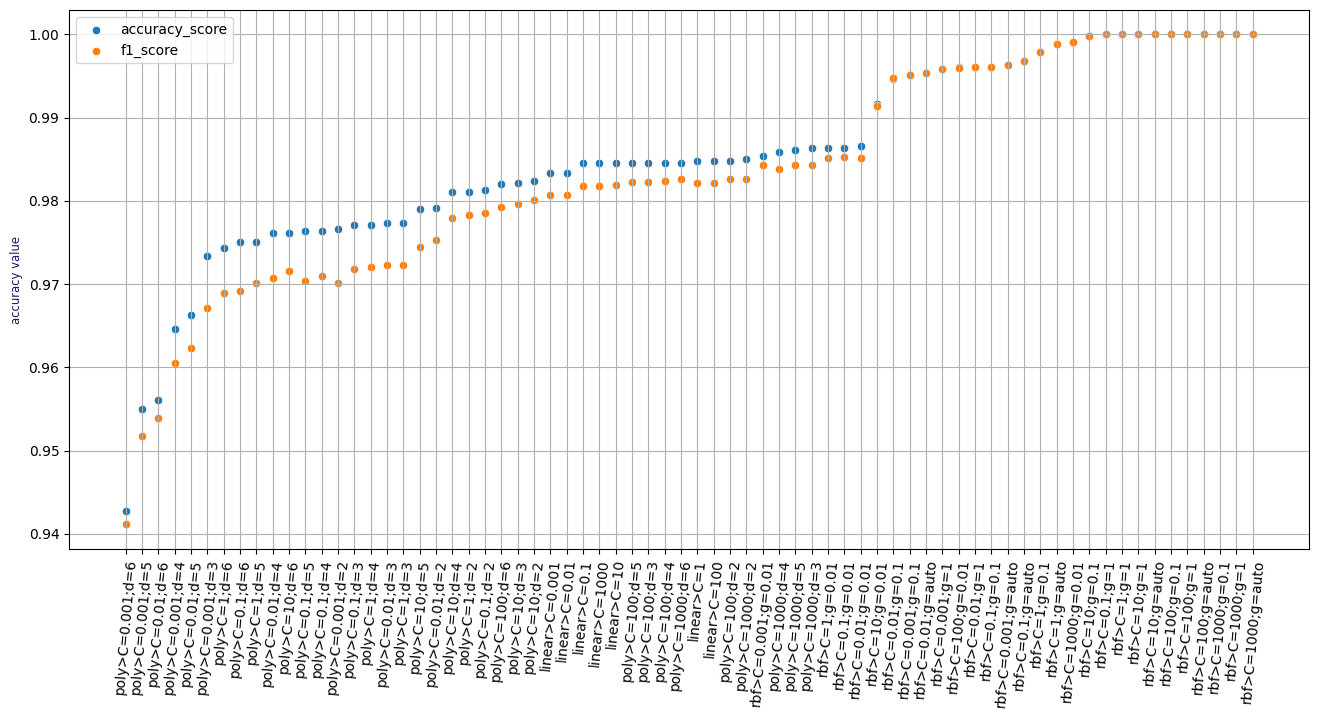

In [78]:
# Порівняння точності за тренувальними вибірками для різних моделей
train_results = train_results.sort_values(by=['accuracy_score', 'f1_score'])
show_compare_accuracy_scatter(x=train_results.index, data=train_results)

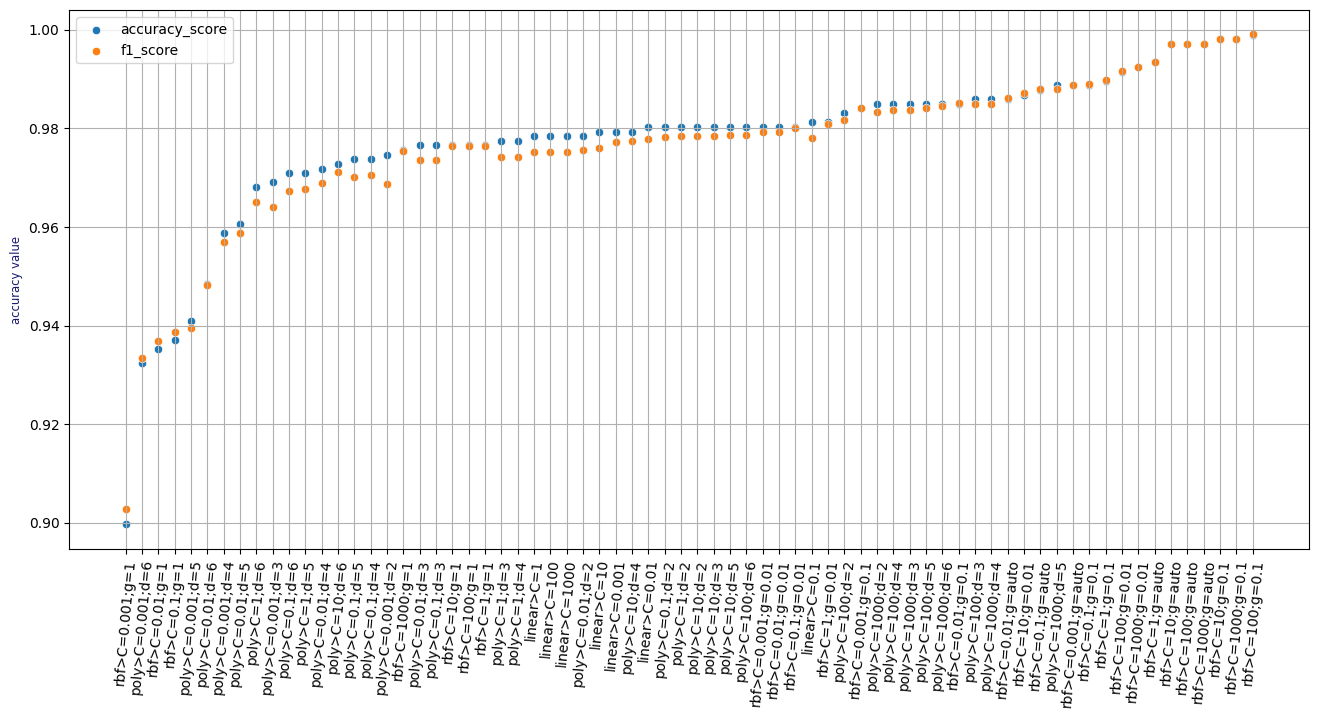

In [79]:
# Порівняння точності за валідаційними вибірками для різних моделей
valid_results = valid_results.sort_values(by=['accuracy_score', 'f1_score'])
show_compare_accuracy_scatter(x=valid_results.index, data=valid_results)

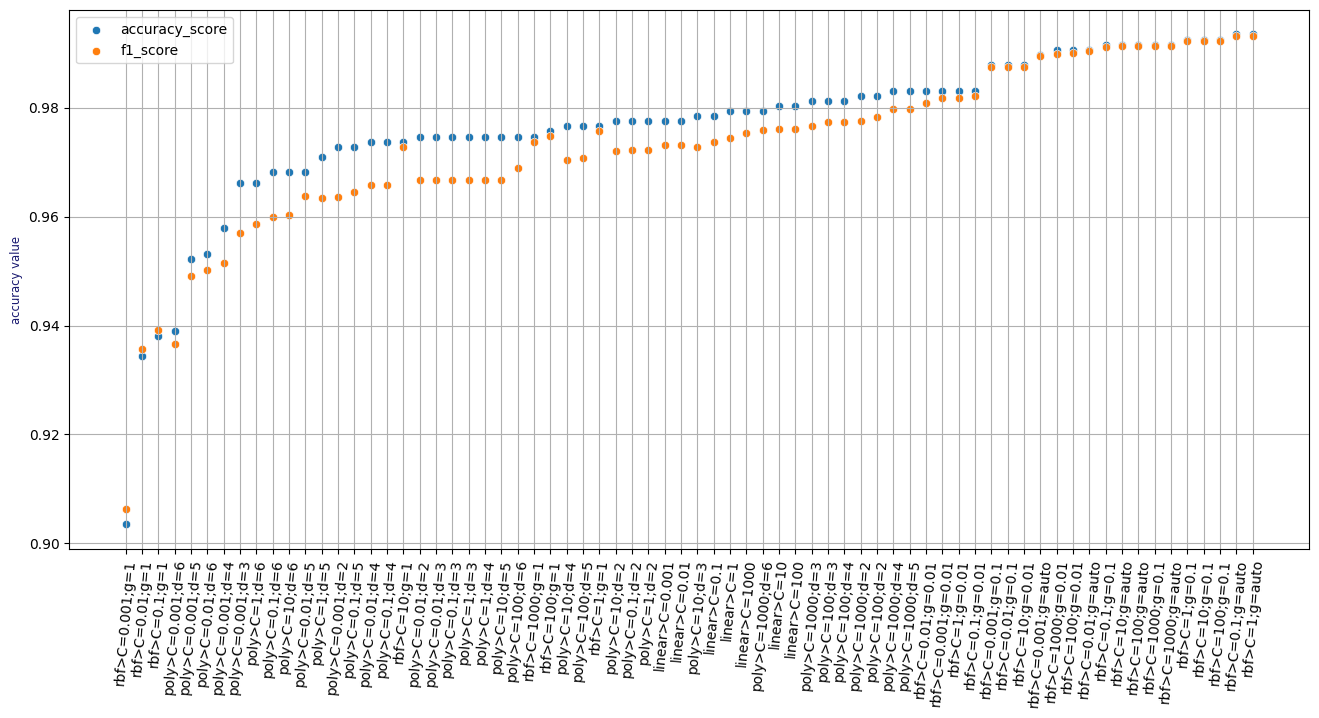

In [80]:
# Порівняння точності за тестовими вибірками для різних моделей
test_results = test_results.sort_values(by=['accuracy_score', 'f1_score'])
show_compare_accuracy_scatter(x=test_results.index, data=test_results)

In [81]:
train_results[train_results['accuracy_score'] >= 0.981].index

Index(['poly>C=10;d=4', 'poly>C=1;d=2', 'poly>C=0.1;d=2', 'poly>C=100;d=6',
       'poly>C=10;d=3', 'poly>C=10;d=2', 'linear>C=0.001', 'linear>C=0.01',
       'linear>C=0.1', 'linear>C=1000', 'linear>C=10', 'poly>C=100;d=5',
       'poly>C=100;d=3', 'poly>C=100;d=4', 'poly>C=1000;d=6', 'linear>C=1',
       'linear>C=100', 'poly>C=100;d=2', 'poly>C=1000;d=2',
       'rbf>C=0.001;g=0.01', 'poly>C=1000;d=4', 'poly>C=1000;d=5',
       'poly>C=1000;d=3', 'rbf>C=1;g=0.01', 'rbf>C=0.1;g=0.01',
       'rbf>C=0.01;g=0.01', 'rbf>C=10;g=0.01', 'rbf>C=0.01;g=0.1',
       'rbf>C=0.001;g=0.1', 'rbf>C=0.01;g=auto', 'rbf>C=0.001;g=1',
       'rbf>C=100;g=0.01', 'rbf>C=0.01;g=1', 'rbf>C=0.1;g=0.1',
       'rbf>C=0.001;g=auto', 'rbf>C=0.1;g=auto', 'rbf>C=1;g=0.1',
       'rbf>C=1;g=auto', 'rbf>C=1000;g=0.01', 'rbf>C=10;g=0.1',
       'rbf>C=0.1;g=1', 'rbf>C=1;g=1', 'rbf>C=10;g=1', 'rbf>C=10;g=auto',
       'rbf>C=100;g=0.1', 'rbf>C=100;g=1', 'rbf>C=100;g=auto',
       'rbf>C=1000;g=0.1', 'rbf>C=1000;g=1

In [82]:
# Подивимося на 'найкращі' моделі за результатом роботи моделей для різних вибірок
valid_results.iloc[-6:], test_results.iloc[-6:]

(                   accuracy_score  f1_score
 rbf>C=10;g=auto          0.997186  0.997161
 rbf>C=100;g=auto         0.997186  0.997161
 rbf>C=1000;g=auto        0.997186  0.997161
 rbf>C=10;g=0.1           0.998124  0.998124
 rbf>C=1000;g=0.1         0.998124  0.998124
 rbf>C=100;g=0.1          0.999062  0.999070,
                    accuracy_score  f1_score
 rbf>C=1000;g=auto        0.991565  0.991253
 rbf>C=1;g=0.1            0.992502  0.992177
 rbf>C=10;g=0.1           0.992502  0.992177
 rbf>C=100;g=0.1          0.992502  0.992291
 rbf>C=0.1;g=auto         0.993440  0.993218
 rbf>C=1;g=auto           0.993440  0.993218)

In [83]:
# Розглянемо поточну версію попередньо вибраної як найкращу linear>C=1
second_result = (train_results.loc['linear>C=1'], valid_results.loc['linear>C=1'], test_results.loc['linear>C=1'])
second_result

(accuracy_score    0.984754
 f1_score          0.982111
 Name: linear>C=1, dtype: float64,
 accuracy_score    0.978424
 f1_score          0.975229
 Name: linear>C=1, dtype: float64,
 accuracy_score    0.979381
 f1_score          0.974521
 Name: linear>C=1, dtype: float64)

In [86]:
# орієнтовний приріст швидкодії моделей при зменшенні з 36 фіч до 7 (= в декілька разів)
(6 * 60 + 5) / (1 * 60 + 50)
(6 * 60 + 30) / (1 * 60 + 41)
(3 * 60 + 54) / (1 * 60 + 57)

2.0

In [85]:
# зменшення точності лінійної моделі 'linear>C=1', орієнтовно
for fr, sr in zip(first_result, second_result):
    print(f'''accuracy_score decrease by {round((1 - sr['accuracy_score']/fr['accuracy_score'])*100, 2)} %\n''')
    print(f'''f1_score decrease by {round((1 - sr['f1_score']/fr['f1_score'])*100, 2)} %\n''')

accuracy_score decrease by 1.09 %

f1_score decrease by 1.35 %

accuracy_score decrease by 1.32 %

f1_score decrease by 1.61 %

accuracy_score decrease by 1.6 %

f1_score decrease by 2.08 %



## Random Forest
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [87]:
number_of_trees = [trees for trees in range(10, 70, 10)]  # 6
models_RF = {f'RF_n_est={items}':RandomForestClassifier(n_estimators=items).fit(X_train, y_train) for items in number_of_trees}

In [88]:
# Порахуємо результати узагальнених точностей за моделями Random Forest для різних вибірок
train_results = get_model_results(X_train, y_train, models_RF)
valid_results = get_model_results(X_valid, y_valid, models_RF)
test_results = get_model_results(X_test, y_test, models_RF)

In [89]:
train_results, valid_results, test_results

(             accuracy_score  f1_score
 RF_n_est=10        0.999538  0.999536
 RF_n_est=20        1.000000  1.000000
 RF_n_est=30        1.000000  1.000000
 RF_n_est=40        1.000000  1.000000
 RF_n_est=50        1.000000  1.000000
 RF_n_est=60        1.000000  1.000000,
              accuracy_score  f1_score
 RF_n_est=10        0.997186  0.997110
 RF_n_est=20        0.997186  0.997253
 RF_n_est=30        0.999062  0.999070
 RF_n_est=40        0.999062  0.999054
 RF_n_est=50        0.999062  0.999054
 RF_n_est=60        0.998124  0.998124,
              accuracy_score  f1_score
 RF_n_est=10        0.991565  0.990783
 RF_n_est=20        0.993440  0.993131
 RF_n_est=30        0.996251  0.996185
 RF_n_est=40        0.993440  0.993383
 RF_n_est=50        0.996251  0.996185
 RF_n_est=60        0.997188  0.997113)